# Using a Deep Q-Network on a multi-stock portfolio

## Retrieving Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import numpy as np
import yfinance as yf

### Function to retrieve data

In [2]:
def retrieve_data(tickr):

    data = yf.download(tickr)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data.columns = columns
    data = data.sort_index(ascending=True)
    data['Change Percentage'] = data['Close'].pct_change() * 100
    data['Force Index'] = data['Close'].diff() * data['Volume']
    
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    money_flow_direction = typical_price.diff()
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    positive_mf = positive_flow.rolling(window=14, min_periods=0).sum()
    negative_mf = negative_flow.rolling(window=14, min_periods=0).sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = positive_mf / negative_mf
        data['Money Flow Index'] = 100 - (100 / (1 + money_ratio))
        data['Money Flow Index'].replace([np.inf], 100, inplace=True)

    data['Price-Volume'] = (data['Close'].pct_change() * data['Volume']).cumsum()
    data['Standard Deviation'] = data['Close'].rolling(window=20).std()
    return data

### Seperating test and train data

In [3]:
def split_data(data, start, end, test_start, test_end):
    train_data = data.loc[start : end]
    test_data = data.loc[test_start : test_end]
    return train_data, test_data

Creating close price dataframe

In [4]:
def retrieve_close(train_data, test_data):
    train_close = train_data['Close']
    test_close = test_data['Close']
    return train_close, test_close

### Normalising data

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def PCA_transform(train_data, test_data):
    # Scaling train data
    state_features = pd.DataFrame({
        'Volume': train_data['Volume'],
        'Change Percentage': train_data['Change Percentage'],
        'Force Index': train_data['Force Index'],
        'Money Flow Index': train_data['Money Flow Index'],
        'Price-Volume': train_data['Price-Volume'],
        'Standard Deviation': train_data['Standard Deviation']
    })
    scaler = MinMaxScaler() # Creating scaler object
    scaled_features_array = scaler.fit_transform(state_features)
    scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)

    # Train data PCA transform
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(scaled_data)

    # Scaling test data
    test_features = pd.DataFrame({
        'Volume': test_data['Volume'],
        'Change Percentage': test_data['Change Percentage'],
        'Force Index': test_data['Force Index'],
        'Money Flow Index': test_data['Money Flow Index'],
        'Price-Volume': test_data['Price-Volume'],
        'Standard Deviation': test_data['Standard Deviation']
    })
    scaled_test_features_array = scaler.transform(test_features) # Using ssame scaler object as train data
    scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

    # PCA transform on test data
    X_test_pca = pca.transform(scaled_test_data)

    return X_train_pca, X_test_pca



### Creating multi-stock vector

In [6]:
asset_tickers = ['AAPL', 'TSLA']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_19541/229767503.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)
[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_19541/229767503.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace 

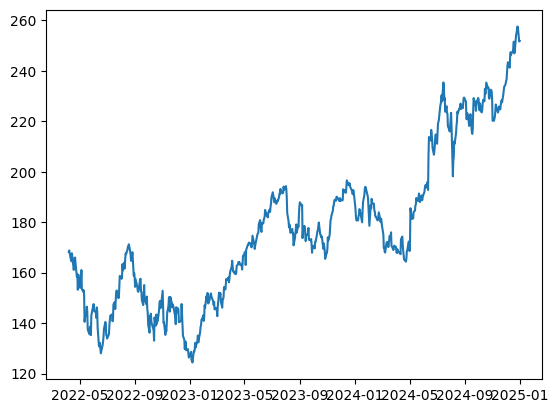

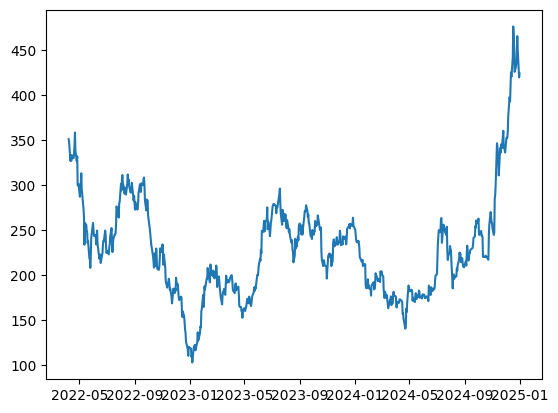

In [7]:
assets_close = []
def get_vector(asset_tickers):
    assets_train_close = []
    assets_test_close = []

    assets_train_pca = []
    assets_test_pca = []
    for i in asset_tickers:
        data = retrieve_data(i)
        data_train, data_test = split_data(data, '2012-02-01', '2022-04-06', '2022-04-07', '2025-01-01')
        
        data_train_close, data_test_close = retrieve_close(data_train, data_test)
        assets_train_close.append(data_train_close)
        assets_test_close.append(data_test_close)

        data_train_pca, data_test_pca = PCA_transform(data_train, data_test)
        assets_train_pca.append(data_train_pca)
        assets_test_pca.append(data_test_pca)

    return assets_train_close, assets_test_close, assets_train_pca, assets_test_pca
train_close, test_close, train_pca, test_pca = get_vector(asset_tickers)
for i in test_close:
    plt.plot(i)
    plt.show()

## Creating Deep Q Network

### Setting up environment

In [8]:
import itertools
import math
ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
STOCKS = ['STOCK_A', 'STOCK_B']

all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))

action_space = [
    list(combo) for combo in all_possible_combos if math.isclose(sum(combo), 1.0)
]
print(action_space)

[[0.0, 1.0], [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1], [1.0, 0.0]]


In [9]:
class environment:

    def __init__(self, price_data, PCA_data):
        self.data = price_data
        self.assets_pca = PCA_data
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0] # Number of shares owned for each stock in portfolio
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []
        self.weight_vector = [0,0]


    #Action = [1,0,0]
    #Action = [-0.5,0.5,0]
    
        

    def step(self, action):

        stocks = self.data
        stock1 = stocks[0]
        trade = [] 
        if self.index <= len(stock1):
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
            total = self.get_net_worth()
            cash_balance = self.balance
            trade.append(total)
            trade.append(action)
            
            

            for i in range(len(action)):
                stock_data = self.data[i]
                

                current_weight = (self.num_shares[i] * stock_data.iloc[self.index]) / total
                
                trade.append(current_weight)
                trade.append(action)
                self.action_history.append(action[i])
                
                
                

                # Checking if action should buy or sell stock
                if action[i] > current_weight:

                    # Calculating cash amount to buy
                    to_buy = (action[i] - current_weight) * total

                    
                    

                    # Calculating new number of shares
                    new_shares = to_buy / stock_data.iloc[self.index]

                    # Adding new shares to total shares
                    self.num_shares[i] += new_shares

                    if self.balance == 100:
                        self.balance -= 100

                
                elif action[i] < current_weight:
                    to_sell = (current_weight - action[i]) * total
                    shares_to_sell = to_sell / stock_data.iloc[self.index]
                    new_num_shares = self.num_shares[i] - shares_to_sell
                    self.num_shares[i] = new_num_shares
                    if self.balance == 100:
                        self.balance -= 100
                        
            
            annual_rate = 0.054
            # Daily risk-free rate
            daily_rate = annual_rate / 365
            self.balance = self.balance * (1+ daily_rate)
            self.balance_history.append(old_net_worth)
            
            
                
           
                
            
            trade.append(self.num_shares)
            trade.append(self.balance)
            

            if self.index < (len(stock1)-1):
                self.index += 1
                
                new_net_worth = self.get_net_worth()
                
    
                # The reward is the change in value
                reward = new_net_worth - old_net_worth
                
                self.trades.append(trade)
                self.total_reward += reward
                self.rewards.append(self.total_reward)
                self.weight_vector = action
            else:
                self.index += 1
                reward = 0
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0]
        self.trend = None
        self.balance_history = []
        self.trades = []
        self.weight_vector = [0,0]
    
    def get_net_worth(self):
        data = self.data
        total = 0
        num_shares = self.num_shares
        for i in range(len(num_shares)):
            price_data = data[i]
            total += num_shares[i] * price_data.iloc[self.index]
        total += self.balance
        return total
        
    def get_state(self):
        state = []
        
        for i in range(len(self.assets_pca)):
            stock_pca = self.assets_pca[i]
            

            current_pca = stock_pca[self.index]
          
            for i in current_pca:
                state.append(i)
        return state


### Training the model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import itertools
import math

# Create the Stock Environment
env = environment(train_close, train_pca)

# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.005
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 2000

ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
STOCKS = ['STOCK_A', 'STOCK_B']

all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))

ACTIONS = [
    list(combo) for combo in all_possible_combos if math.isclose(sum(combo), 1.0)
]

# Initialize Q-networks
input_dim = 8
output_dim = 11
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, len(ACTIONS) - 1)  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()
        

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)

    state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)
    state_batch = torch.FloatTensor(np.array(state_batch, dtype=np.float32))

    state_batch = torch.FloatTensor(state_batch)
    
 
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    

    # Compute Q-values for current states

    # Now the gather operation will work
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
steps_done = 0

for episode in range(episodes):
    state = env.get_state()
    done = False
    i = 0
    for i in range(len(train_close[i])-1):
        # Select action
        action_index = select_action(state, epsilon)
       
        action = ACTIONS[action_index]
        reward, done = env.step(action)
        
        next_state = env.get_state()
        # Store transition in memory
        memory.append((state, action_index, reward, next_state))
        
        # Update state
        state = next_state

        # Optimize model
        optimize_model()
        steps_done += 1

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())


    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    env.reset()


## Testing

In [11]:
def test(env):
    
    # Reset the environment
    env.reset()  

    step = 0
    done = False
    action_history = []
    sum = 0
    stock1 = test_close[0]
    
    while env.index < (len(stock1)):
   
        state = env.get_state()
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]
       

        env.step(action)
        sum += 1
        
     

        if done:
            break
   

In [12]:
test_env = environment(test_close, test_pca)
test(test_env)

### Assigning history values to dates

In [13]:
print((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])

0.7066807829651214


In [14]:
df1 = pd.DataFrame(test_close[0])
df1.columns = ['Close']
df1['Model_Balance'] = test_env.balance_history
print(df1)

                 Close  Model_Balance
Date                                 
2022-04-07  168.210233     100.000000
2022-04-08  168.819538      99.498059
2022-04-11  165.802504      94.771174
2022-04-12  165.124365      95.821454
2022-04-13  164.505213      94.600278
...                ...            ...
2024-12-24  254.875189     172.043850
2024-12-26  257.568678     175.808066
2024-12-27  257.209530     174.429717
2024-12-30  251.623005     169.061337
2024-12-31  251.832511     170.668078

[687 rows x 2 columns]


### Plotting model performace against underlying stock price

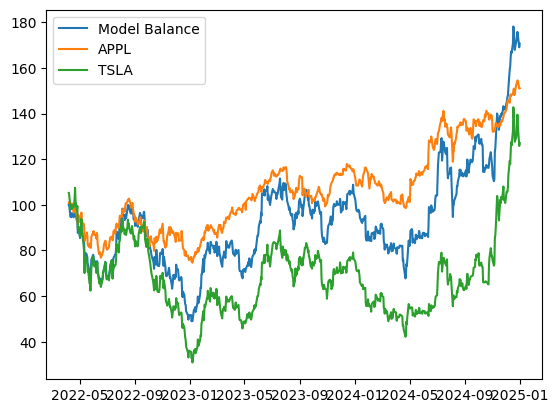

In [16]:
plt.plot(df1['Model_Balance'], label="Model Balance")
plt.plot(test_close[0] * 0.6, label="APPL")
plt.plot(test_close[1] * 0.3, label="TSLA")
plt.legend()
plt.show()